In [113]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, precision_score, recall_score,f1_score
from sklearn import metrics as mt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [129]:
#import data
df = pd.read_csv("C:/Users/nedei/Documents/School/QTW/log2.csv")

#create supported columns list
df = df[['Source Port','Destination Port','NAT Source Port','NAT Destination Port','Target']]
#rename columns for easier use
df = df.set_axis(['SourcePort','DestinationPort','NatSourcePort','NatDestPort','Target'],axis = 1)

#quick data conversion and clean
df['SourcePort'] = df['SourcePort'].astype('str')
df['DestinationPort'] = df['DestinationPort'].astype('str')
df['NatSourcePort'] = df['NatSourcePort'].astype('str')
df['NatDestPort'] = df['NatDestPort'].astype('str')
df['SourcePort'] = df['SourcePort'].str.replace('.0', '')
df['DestinationPort'] = df['DestinationPort'].str.replace('.0', '')
df['NatSourcePort'] = df['NatSourcePort'].str.replace('.0', '')
df['NatDestPort'] = df['NatDestPort'].str.replace('.0', '')

#dataframe info check
df.head()
#number of unique values check
df.nunique()

SourcePort         15738
DestinationPort     2587
NatSourcePort      20240
NatDestPort         2047
Target                 2
dtype: int64

In [88]:
sourceport_info = df[['SourcePort','Target']]
sourceport_info = sourceport_info.groupby(['SourcePort','Target']).size().reset_index()
sourceport_info = sourceport_info.set_axis(['SourcePort','Target','Count'], axis = 1)
spallow = sourceport_info[sourceport_info['Target'] == 1]
spdeny = sourceport_info[sourceport_info['Target'] == 0]

destport_info = df[['DestinationPort','Target']]
destport_info = destport_info.groupby(['DestinationPort','Target']).size().reset_index()
destport_info = destport_info.set_axis(['DestinationPort','Target','Count'], axis = 1)
dpallow = destport_info[destport_info['Target'] == 1]
dpdeny = destport_info[destport_info['Target'] == 0]

natdestport_info = df[['NatDestPort','Target']]
natdestport_info = natdestport_info.groupby(['NatDestPort','Target']).size().reset_index()
natdestport_info = natdestport_info.set_axis(['NatDestPort','Target','Count'], axis = 1)
ndpallow = natdestport_info[natdestport_info['Target'] == 1]
ndpdeny = natdestport_info[natdestport_info['Target'] == 0]
ndpallow = ndpallow.drop(('Target'),axis = 1)
ndpdeny = ndpdeny.drop(('Target'),axis = 1)

<BarContainer object of 9676 artists>

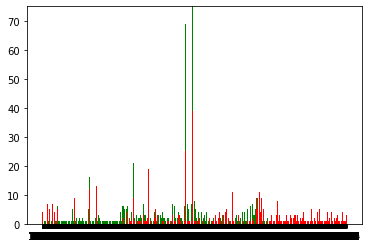

In [80]:
import matplotlib.pyplot as plt

x = spallow['SourcePort']
y1 = spallow['Count']

  
# plot bars in stack manner
#axes.set_ylim(0,100)
plt.ylim((0,75))
plt.bar(x, y1, color='g')
x = spdeny['SourcePort']
y1 = spdeny['Count']

  
# plot bars in stack manner
plt.ylim((0,75))
plt.bar(x, y1, color='r')

<BarContainer object of 696 artists>

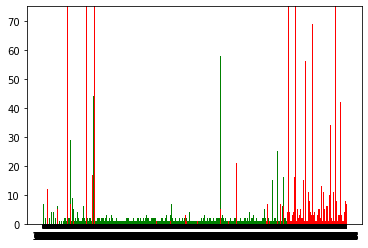

In [81]:
x = dpallow['DestinationPort']
y1 = dpallow['Count']

  
# plot bars in stack manner
#axes.set_ylim(0,100)
plt.ylim((0,75))
plt.bar(x, y1, color='g')

x = dpdeny['DestinationPort']
y1 = dpdeny['Count']

  
# plot bars in stack manner
plt.ylim((0,75))
plt.bar(x, y1, color='r')

<BarContainer object of 8 artists>

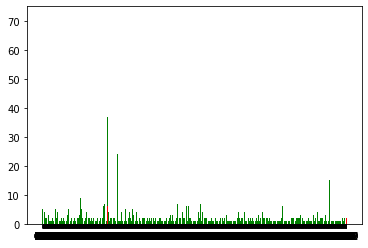

In [82]:
x = ndpallow['NatDestPort']
y1 = ndpallow['Count']

  
# plot bars in stack manner
#axes.set_ylim(0,100)
plt.ylim((0,75))
plt.bar(x, y1, color='g')

x = ndpdeny['NatDestPort']
y1 = ndpdeny['Count']

  
# plot bars in stack manner
plt.ylim((0,75))
plt.bar(x, y1, color='r')

In [144]:
#can see clear skewing of one port over another. Create cohort tier system for Natural Destination Port
npd = ndpallow.merge(ndpdeny,on = ['NatDestPort'],how = 'outer')
npd = npd.fillna(0)
npd = npd.set_axis(['NatDestPort','Allows','Denies'],axis = 1)
npd['TotalHits'] = npd['Allows'] + npd['Denies']
npd['AllowPer'] = npd['Allows']/npd['TotalHits']
npd['DenyPer'] = npd['Denies']/npd['TotalHits']
npd['AllowPerDiff'] = npd['AllowPer']-npd['DenyPer']
npd.loc[npd['AllowPerDiff'] < 0, 'NDPortTier'] = '4'
npd.loc[npd['AllowPerDiff'] > 0, 'NDPortTier'] = '3'
npd.loc[npd['AllowPerDiff'] > .5, 'NDPortTier'] = '2'
npd.loc[npd['AllowPerDiff'] > .8, 'NDPortTier'] = '1'
blacklist = npd[npd['DenyPer'] > .75]
blacklist.head()

,NatDestPort,Allows,Denies,TotalHits,AllowPer,DenyPer,AllowPerDiff,NDPortTier
1,0,655.0,27868.0,28523.0,0.022964,0.977036,-0.954072,4
2044,5169,0.0,1.0,1.0,0.000000,1.000000,-1.000000,4
2045,8887,0.0,1.0,1.0,0.000000,1.000000,-1.000000,4
2046,8889,0.0,2.0,2.0,0.000000,1.000000,-1.000000,4


In [145]:
npd = npd[['NatDestPort','NDPortTier']]
df1 = df.merge(npd, on = ['NatDestPort'], how = 'left')
df1['NDPortTier'] = df1['NDPortTier'].fillna('0')

df1.head(100)

,SourcePort,DestinationPort,NatSourcePort,NatDestPort,Target,NDPortTier
0,57222,53,54587,53,1,1
1,56258,3389,56258,3389,1,1
2,6881,321,43265,321,1,1
3,553,3389,553,3389,1,1
4,2,443,45848,443,1,1
...,...,...,...,...,...,...
95,61442,443,19223,443,1,1
96,9446,443,836,443,1,1
97,52194,443,38386,443,1,1
98,586,443,59387,443,1,1


In [147]:
#begin build model

#onehotencoding
tmp_df = pd.get_dummies(df1.NDPortTier,prefix='NDPortTier')
df_onehot = pd.concat((df1,tmp_df),axis=1) # add back into the dataframe

#create target and data
target = df_onehot[['Target']]
data = df_onehot.drop(['SourcePort','DestinationPort','NatSourcePort','NatDestPort','NDPortTier','Target'], axis = 1)

#create train test
X_train,X_test,Y_train,Y_test = train_test_split(data,target,test_size=0.80,random_state=0,stratify=target) #start with small to train svm quickly

#scaled data
scl_obj = StandardScaler()
X_train = scl_obj.fit_transform(X_train, y = None)
X_test = scl_obj.fit_transform(X_test, y = None)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65532 entries, 0 to 65531
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   NDPortTier_1  65532 non-null  uint8
 1   NDPortTier_2  65532 non-null  uint8
 2   NDPortTier_4  65532 non-null  uint8
dtypes: uint8(3)
memory usage: 704.0 KB


AUC: 0.9908302005755548 Precision: 0.9994931576279777 ACC: 0.9895662457559227 F1 Score: 0.9908385951395983


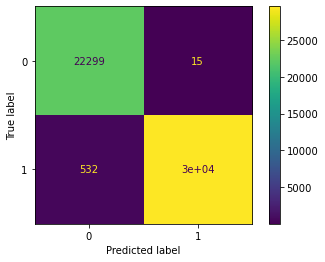

In [148]:
#first SVM model
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
# train the model
svm_clf = SVC(C=0.5, kernel='rbf', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(X_train,Y_train.values.ravel())
yhat = svm_clf.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
recall = mt.recall_score(Y_test,yhat)
f1 = 2*((prec*recall)/(prec+recall))
print('AUC:',auc,'Precision:',prec,'ACC:',acc,'F1 Score:',f1)
plot_confusion_matrix(svm_clf,X_test,Y_test)

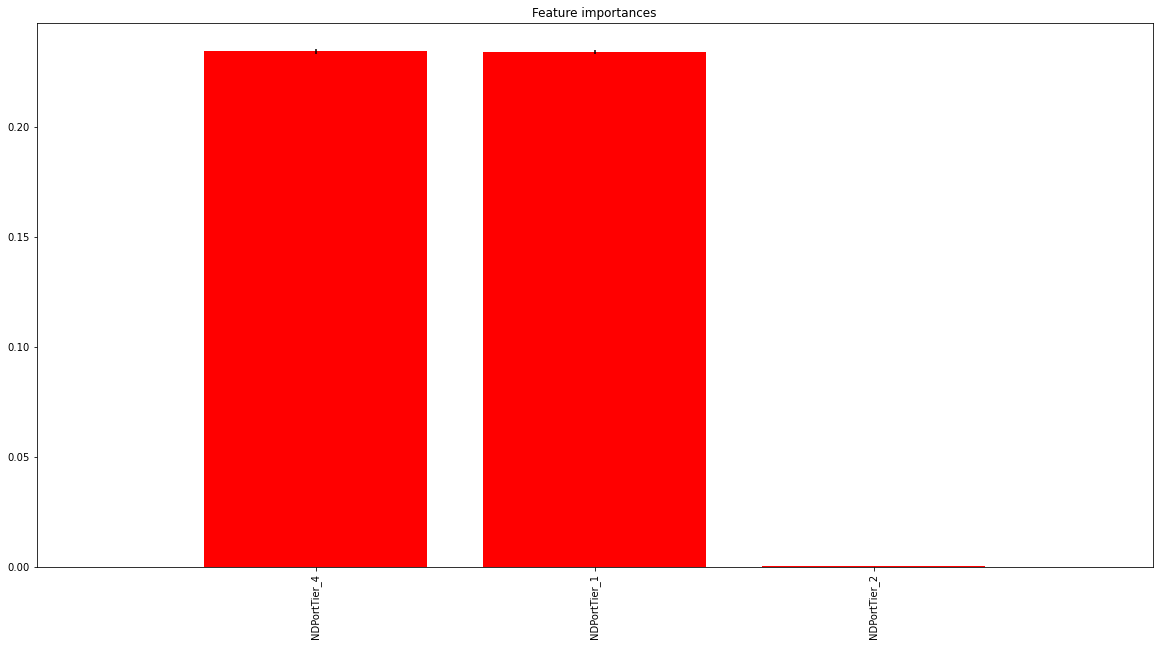

In [149]:
from sklearn.feature_selection import RFECV
features = list(data.columns.values)


from sklearn.inspection import permutation_importance

imps = permutation_importance(svm_clf, X_test, Y_test)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking

featureorder = []

for f in range(X_test.shape[1]):
    featureorder.append(features[indices[f]])
featurecount = len(featureorder)
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), [features[indices[i]] for i in range(featurecount)],rotation = 90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

In [135]:
blacklist.head()

,NatDestPort,Allows,Denies,TotalHits,AllowPer,DenyPer,AllowPerDiff,NDPortTier
0,0,655,27868,28523,0.022964,0.977036,-0.954072,4
